In [10]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [12]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [13]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [14]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [15]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [16]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [17]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [18]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

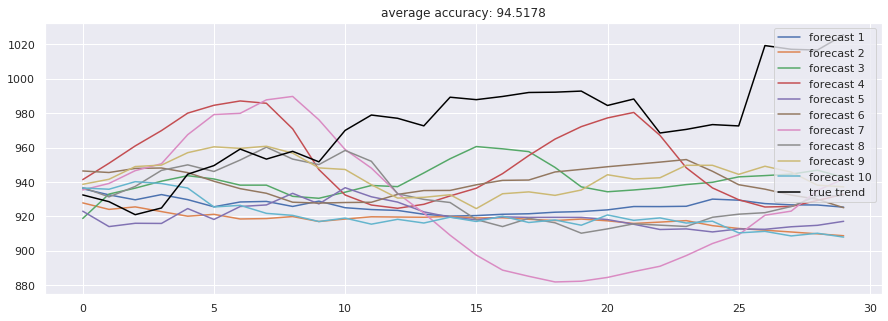

In [12]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

2025-03-23 16:26:16.326182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 16:26:16.372988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742718376.419620  114056 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742718376.433911  114056 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742718376.464820  114056 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

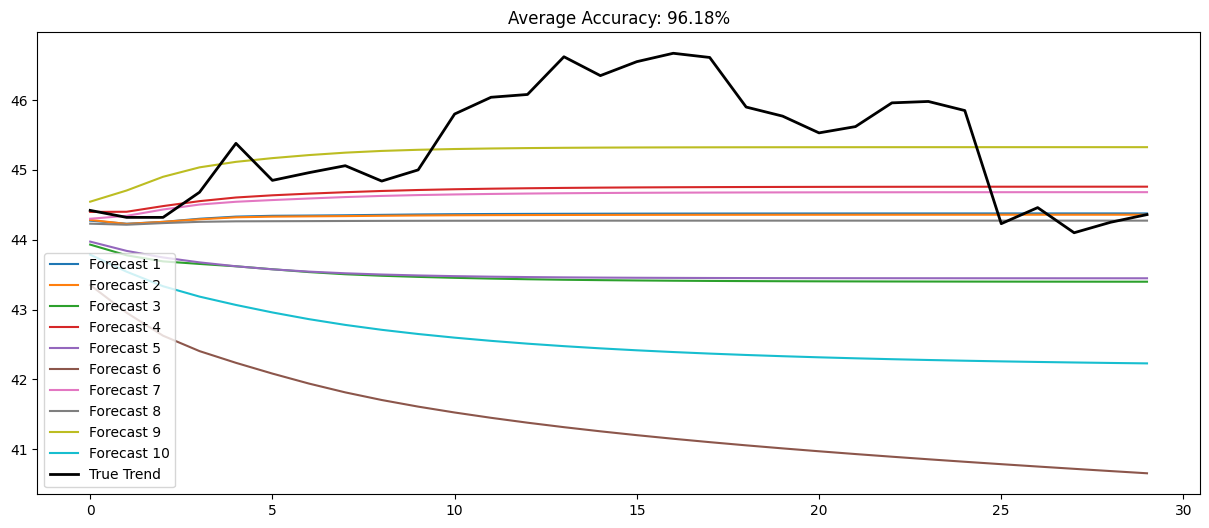

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
from tqdm import tqdm

# Load Data
df = pd.read_csv('/home/priya/Desktop/fyp/Agents/data_store/D05.SI.csv')

# Scale the Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Close']])

# Split Data
TEST_SIZE = 30
SIMULATIONS = 10

train_data = df_scaled[:-TEST_SIZE]
test_data = df_scaled[-TEST_SIZE:]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 5
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)

# Model Definition
def build_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(SEQ_LENGTH, 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

def calculate_accuracy(real, predict):
    real, predict = np.array(real) + 1, np.array(predict) + 1
    return (1 - np.sqrt(np.mean(np.square((real - predict) / real)))) * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

# Forecasting Function
def forecast():
    model = build_model()
    model.fit(X_train, y_train, epochs=300, batch_size=16, verbose=0)

    forecast_data = train_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)

    predictions = []
    for _ in range(TEST_SIZE):
        pred = model.predict(forecast_data, verbose=0)
        predictions.append(pred[0, 0])
        forecast_data = np.append(forecast_data[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    predictions = anchor(predictions, 0.3)

    return predictions

# Running Simulations
results = []
for i in tqdm(range(SIMULATIONS), desc='Simulations'):
    results.append(forecast())

# Evaluate Accuracy
accuracies = [calculate_accuracy(df['Close'].iloc[-TEST_SIZE:], result) for result in results]

# Plotting
plt.figure(figsize=(15, 6))
for idx, result in enumerate(results):
    plt.plot(result, label=f'Forecast {idx+1}')

plt.plot(df['Close'].iloc[-TEST_SIZE:].values, label='True Trend', color='black', linewidth=2)
plt.title(f'Average Accuracy: {np.mean(accuracies):.2f}%')
plt.legend()
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# Load Data
df = pd.read_csv('/home/priya/Desktop/fyp/Agents/benchmark_C38U_traindf.csv')

# Scale the Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['yref_Tm0_close']])

# Split Data
TEST_SIZE = 30
SIMULATIONS = 10

train_data = df_scaled[:-TEST_SIZE]
test_data = df_scaled[-TEST_SIZE:]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 5
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)

# Model Definition
def build_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(SEQ_LENGTH, 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

def calculate_accuracy(real, predict):
    real, predict = np.array(real) + 1, np.array(predict) + 1
    return (1 - np.sqrt(np.mean(np.square((real - predict) / real)))) * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

# Forecasting Function
def forecast():
    model = build_model()
    model.fit(X_train, y_train, epochs=300, batch_size=16, verbose=0)

    forecast_data = train_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)

    predictions = []
    for _ in range(TEST_SIZE):
        pred = model.predict(forecast_data, verbose=0)
        predictions.append(pred[0, 0])
        forecast_data = np.append(forecast_data[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    predictions = anchor(predictions, 0.3)

    return predictions

# Running Simulations
results = []
r2_scores, rmses, accuracies = [], [], []
true_values = df['yref_Tm0_close'].iloc[-TEST_SIZE:].values

for i in tqdm(range(SIMULATIONS), desc='Simulations'):
    preds = forecast()
    results.append(preds)

    r2 = r2_score(true_values, preds)
    rmse = np.sqrt(mean_squared_error(true_values, preds))
    acc = calculate_accuracy(true_values, preds)

    r2_scores.append(r2)
    rmses.append(rmse)
    accuracies.append(acc)

# Print evaluation metrics
print(f"\nAverage R2 Score: {np.mean(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmses):.4f}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}%")

# Plotting
plt.figure(figsize=(15, 6))
for idx, result in enumerate(results):
    plt.plot(result, label=f'Forecast {idx+1}')

plt.plot(true_values, label='True Trend', color='black', linewidth=2)
plt.title(f'Bidirectional LSTM Forecasting\nAvg R²: {np.mean(r2_scores):.4f}, RMSE: {np.mean(rmses):.4f}, Accuracy: {np.mean(accuracies):.2f}%')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


2025-03-27 11:47:50.159482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 11:47:50.192973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743047270.232246   12377 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743047270.243127   12377 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743047270.272119   12377 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

KeyboardInterrupt: 